# Transfer Learning With Tensorflow Part 2: Fine-Tuning

## What is transfer learning ?

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

- Can leverage an existing neural network architecture prove to work on problem similiar to our own
- Can leverage a working network architecture which has already learned patterns on similiar data to our own (often results in great results with less data)

Surely someone has spent the time crafting the right model for the job..

Example Transfer Learning use cases:

- Computer vision see: https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview
- Natural Language Proccessing

## What we're goint to cover
- Introduce **fine-tuning transfer learning** with Tensorflow
- Introduce the **Keras Functional API** to build models
- Using a small dataset to experiments faster (e.g 10% of training samples)
- **Data Augmentation** (making your training set more diverse without adding samples)
- Runing a series of experiments on our food vision data
- Introduce the ModelCheckpoint callback to save intermediate training results

- **What is Transfer Learning?**  
Surely someone has spent the time crafting the right model for the job...
- **Why use transfer learning?**  
    - can leverage an existing neural network architeture proven to work on problem similar to our own
    - can leverage a working network architeture which has already learned patterns on similiar data to our own
    

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib as mt
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
STORAGE = os.path.join('..', 'storage')
IMAGE_PATH = f'{STORAGE}/images'
ZIP_PATH = f'{STORAGE}/zip'
MODEL_PATH = f'{STORAGE}/models'
TRANSFER_LEARNING_PATH = f'{STORAGE}/transfer_learning'

# concat paths
LIST_PATHS = [IMAGE_PATH, ZIP_PATH, MODEL_PATH, TRANSFER_LEARNING_PATH]

In [4]:
for dir in LIST_PATHS:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [5]:
import zipfile
import urllib.request as ur
import shutil

filename = '10_food_classes_10_percent.zip'
url = f'https://storage.googleapis.com/ztm_tf_course/food_vision/{filename}'

if not os.path.exists(f'{ZIP_PATH}/{filename}'):
    # download zip file
    ur.urlretrieve(url, filename)
    shutil.move(filename, f'{ZIP_PATH}')

# unzip the download file
zip_ref = zipfile.ZipFile(f'{ZIP_PATH}/{filename}', 'r')

# remove folder if exist
folder = filename.split('.')[0]
if os.path.isdir(f'{TRANSFER_LEARNING_PATH}/{folder}'):
    shutil.rmtree(f'{TRANSFER_LEARNING_PATH}/{folder}')

zip_ref.extractall(f'{TRANSFER_LEARNING_PATH}')
zip_ref.close()

In [6]:
# How many images in each folder
for dirpath, dirnames, filenames in os.walk(f'{TRANSFER_LEARNING_PATH}/{folder}'):
    print(f'dir: {len(dirnames)} images: {len(filenames)} path: {dirpath}')

dir: 2 images: 0 path: ..\storage/transfer_learning/10_food_classes_10_percent
dir: 10 images: 0 path: ..\storage/transfer_learning/10_food_classes_10_percent\test
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\chicken_curry
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\chicken_wings
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\fried_rice
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\grilled_salmon
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\hamburger
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\ice_cream
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\pizza
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\ramen
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_

## Creating helper functions
In previous noutebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedius.

see: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [7]:
import urllib.request as ur
# uncomment this line under and run it to download helper_functions file
# ur.urlretrieve('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py', filename='helper_functions.py')

In [8]:
# import helper functions we're goint to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

see: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [9]:
walk_through_dir(f'{TRANSFER_LEARNING_PATH}/{folder}')

There are 2 directories and 0 images in '..\storage/transfer_learning/10_food_classes_10_percent'.
There are 10 directories and 0 images in '..\storage/transfer_learning/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classe

In [10]:
train_dir = f'{TRANSFER_LEARNING_PATH}/{folder}/train'
test_dir = f'{TRANSFER_LEARNING_PATH}/{folder}/test'

In [11]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
LABEL_MODEL = 'categorical'

print(f'Training images:')
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                          image_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          label_mode=LABEL_MODEL)

print(f'Testing images:')
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        label_mode=LABEL_MODEL)

Training images:
Found 750 files belonging to 10 classes.
Testing images:
Found 2500 files belonging to 10 classes.


In [12]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

## Dataset shapes

Create batches of 32 images of size 224x224 split into red, green, blue colour channels.

<ul>
    <li style='color: #0099ff;'>Number of total samples (750 images, 75 per class)</li>
    <li style='color: skyblue;'>Number of classes (10 types of food)</li>
    <li style='color: lightgreen;'>Batch size (default 32)</li>
    <li style='color: #FFBF00;'>Image size (height, width)</li>
    <li style='color: salmon;'>Number of colour channels (red, green, blue)</li>
    <li style='color: grey;'>Number of classes in label tensors (10 types of food)</li>
</ul>

In [13]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

<div style='display: flex; align-items: center; gap: 16px;'>
    <div style='border: 1px solid grey; padding: 8px; flex: 0.8'>
        <strong>Sequential API</strong>
        <pre style='font-size: 0.8rem;'>
            # create a model with the Sequential API
            sequential_model = tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax')
            ], name='sequential_model')
            sequential_model.compile(
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy']
            )
            sequential_model.fit(x_train, 
                                y_train, 
                                batch_size=32, 
                                epoches=5)
        </pre>
    </div>
    <div style='flex: 0.1; text-align: center'>vs</div>
    <div style='border: 1px solid grey; padding: 8px; flex: 0.8'>
    <strong>Functional API</strong>
     <pre style='font-size: 0.8rem;'>
            # create a model with the Functional API
            inputs = tf.keras.layers.Input(shape=(28, 28))
            x = tf.keras.layers.Flatten()(inputs)
            x = tf.keras.layers.Dense(64, activation='relu')(x)
            x = tf.keras.layers.Dense(64, activation='relu')(x)
            outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
            functional_model = tf.keras.Model(inputs, outputs, name='functional_model')
            functional_model.compile(
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy']
            )
            functional_model.fit(x_train, 
                                y_train, 
                                batch_size=32, 
                                epoches=5)
        </pre>
    </div>
</div>

- Similarities: compiling, fitting, evalutating
- Differences: model construction (the Function API is more flexible and able to produce more sophisticated models)

## Model 0: Building a transfer learning model using Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order, but the functional API gives us more flexibility with our models:  
see: https://www.tensorflow.org/guide/keras/functional

In [14]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. freeze the base model (so the underlying pre-trained patterns aren't updated during training
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs the model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer (10 is the number of classes labels)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs, name='function_model_0')

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent, epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)), 
                                 callbacks=[create_tensorboard_callback(dir_name=f'{TRANSFER_LEARNING_PATH}/tensorflow_hub', 
                                                                                    experiment_name='10_percent_feature_extraction')])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: ..\storage/transfer_learning/tensorflow_hub/10_percent_feature_extraction/20240302-083059
Epoch 1/5
24/24 [==============================] - 72s 2s/step - loss: 1.9151 - accuracy: 0.3747 - val_loss: 1.3111 - val_accuracy: 0.7368
Epoch 2/5
24/24 [==============================] - 10s 192ms/step - loss: 1.1198 - accuracy: 0.7467 - val_loss: 0.8761 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 4s 176ms/step - loss: 0.8036 - accuracy: 0.8133 - val_loss: 0.6896 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 4s 177ms/step - loss: 0.6513 - accuracy: 0.8533 - val_loss: 0.6045 - val_accuracy: 0.8553
Epoch 5/5
24/24 [==============================] - 4s 178ms/step - loss: 0.5567 - accuracy: 0.8773 - val_loss: 0.5662 - val_accuracy: 0.8618


```python
    # ResNet50V2 you will need to normalize inputs
    # x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    tf.keras.applications.ResNet50V2(
        includes_top=False, weights='imagenet', input_tensor=None,
        input_shape=None, pooling=None, classes=1000,
        classifier_activation='softmax'
    )
```

In [15]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 35s 449ms/step - loss: 0.5588 - accuracy: 0.8656


[0.5588278770446777, 0.8655999898910522]

In [16]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [17]:
model_0.summary()

Model: "function_model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


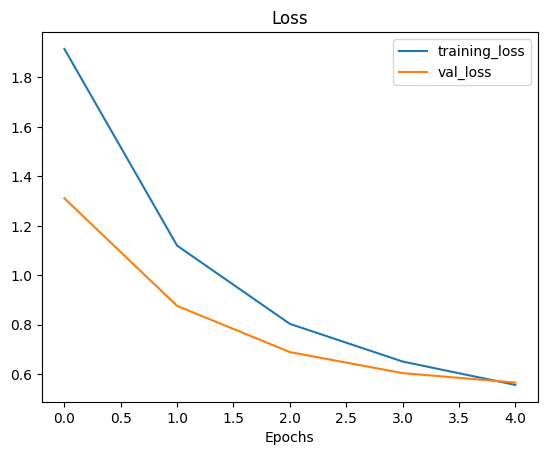

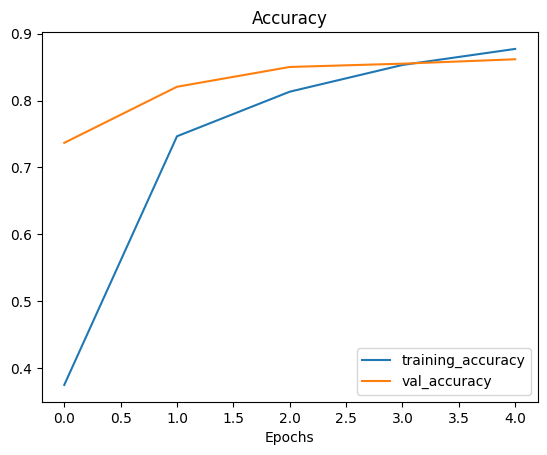

In [18]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D Layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then wen it passes through GlobalAveragePooling2D, it turns into (None, 1280).
Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [19]:
# Difine the input shape
input_shape = (1, 4, 4, 3)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D Layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor: \n {global_average_pooled_tensor}\n')

# check the shape of the different tensors
print(f'Shpe of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3760557  -1.4474666  -1.2757354 ]
   [-0.13766558 -0.4681063  -0.830276  ]
   [-1.154335   -1.8472948   0.21073243]
   [-1.1102556   0.1823509   0.69556814]]

  [[-0.86371315  0.1572404   0.15890531]
   [ 1.4685823   0.29341125 -0.2982713 ]
   [ 0.03712223 -0.03236742 -0.17708328]
   [-0.10624988 -0.77748936 -1.017031  ]]

  [[-0.0195812  -0.08722717  0.40012318]
   [ 1.3685222   0.04846301  0.25690517]
   [-0.7570979  -0.6971549  -0.25610995]
   [-1.0401741   0.68112653  0.67976266]]

  [[ 0.20820473 -0.17182551 -0.7867398 ]
   [ 0.08172861 -0.8712386  -1.3890613 ]
   [-0.2060933   1.1751838   0.16154127]
   [-0.09697878 -1.6301028  -0.71867365]]]]

2D global average pooled random tensor: 
 [[-0.12199555 -0.3432811  -0.26159024]]

Shpe of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [20]:
# Let's replicate the GlobalAveragePool2D
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.12199555, -0.3432811 , -0.26159024]], dtype=float32)>

> **Pratice** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.
>
>
> **Note** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model
> outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case
> this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific problem.

## What is a feature vector?

- A feature vector is a `learned representation of the input data` (a compressed form of the input data dabased on how the model see's it)



```mermaid
graph
    A[Input Data] --> 
    B[Model learns feature representations of input data] -->
    C[Output - feature vector]
```


 ## Running a series of transfer learning experiments

 We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of training data... how about we set up a bunch of experiments to find out:

 1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
 2. `model_2` - use feature extraction transfer learning with 10% of training data with data augmentation.
 3. `model_3` - use fine-tuning transfer learning on 10% of training data with data augmentation.
 4. `model_4` - use fine-tuning transfer learning on 100% of training data with data augmentation.

 > **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evalutation metrics.

In [21]:
# Downlaod and unzip data - preprocessed from food101

import zipfile
import urllib.request as ur
import shutil

filename_1_percent = '10_food_classes_1_percent.zip'
url = f'https://storage.googleapis.com/ztm_tf_course/food_vision/{filename_1_percent}'

if not os.path.exists(f'{ZIP_PATH}/{filename_1_percent}'):
    # download zip file
    ur.urlretrieve(url, filename_1_percent)
    shutil.move(filename_1_percent, f'{ZIP_PATH}')

# unzip the download file
zip_ref = zipfile.ZipFile(f'{ZIP_PATH}/{filename_1_percent}', 'r')

# remove folder if exist
folder_1_percent = filename_1_percent.split('.')[0]
if os.path.isdir(f'{TRANSFER_LEARNING_PATH}/{folder_1_percent}'):
    shutil.rmtree(f'{TRANSFER_LEARNING_PATH}/{folder_1_percent}')

zip_ref.extractall(f'{TRANSFER_LEARNING_PATH}')
zip_ref.close()

In [22]:
# create training and test data
train_dir_1_percent = f'{TRANSFER_LEARNING_PATH}/{folder_1_percent}/train'
test_dir = f'{TRANSFER_LEARNING_PATH}/{folder_1_percent}/test'

In [23]:
# how many images are we working with?
walk_through_dir(f"{TRANSFER_LEARNING_PATH}/{folder_1_percent}")

There are 2 directories and 0 images in '..\storage/transfer_learning/10_food_classes_1_percent'.
There are 10 directories and 0 images in '..\storage/transfer_learning/10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_1_perc

In [24]:
# setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32
LABEL_MODEL = 'categorical'

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode=LABEL_MODEL,
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default 32

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode=LABEL_MODEL,
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

- [`tf.keras.layers.experimental.preprocessing()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing)

We can see the benefis of doing this within the Tensorflow Data Augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation?hl=pt-br

off the top our of heads, after reading docs, the benefits of using data augmentation inside the model are:
- processing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
- image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

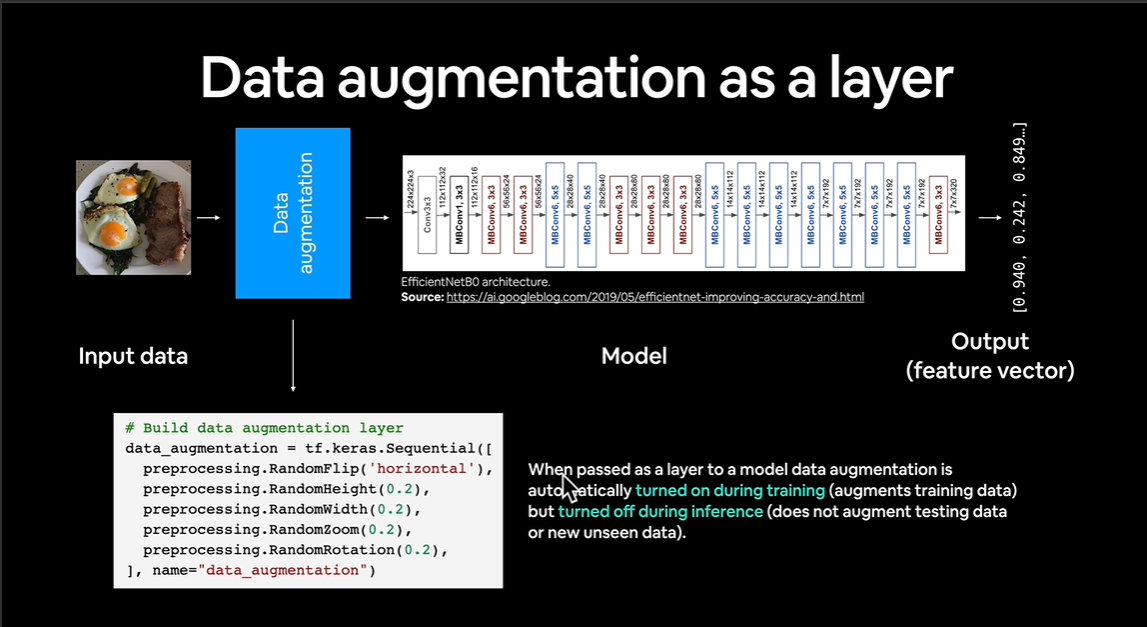

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [26]:
# create data augmentation stage with horizontal flipping, rotation, zooms etc..
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # keep for models like ResNet50v2 but EfficientNet's having resclaing built-in
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

In [27]:
# View a random image and compare it to its augmented version
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(-0.5, 514.5, 513.5, -0.5)

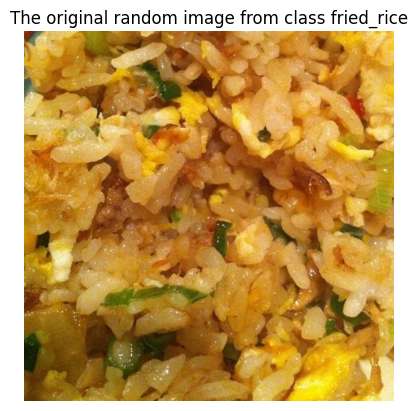

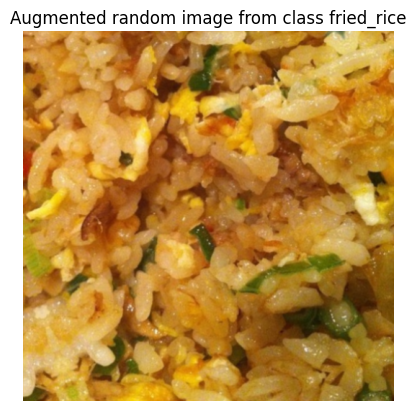

In [28]:
# random image from directory

target_class = random.choice(train_data_1_percent.class_names)
target_dir = f'{train_dir_1_percent}/{target_class}'
random_image = random.choice(os.listdir(target_dir))
random_image_path = f'{target_dir}/{random_image}'

# read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'The original random image from class {target_class}')
plt.axis(False)

# read in the random augmented image
augmentation_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(tf.squeeze(augmentation_img)/255.)
plt.title(f'Augmented random image from class {target_class}')
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of data with data augmentation

In [29]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base_model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name=f'{TRANSFER_LEARNING_PATH}/tensorflow_hub', 
                                                                                    experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: ..\storage/transfer_learning/tensorflow_hub/1_percent_data_aug/20240302-083400
Epoch 1/5
3/3 [==============================] - 33s 10s/step - loss: 2.4864 - accuracy: 0.1000 - val_loss: 2.2528 - val_accuracy: 0.1645
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1595 - accuracy: 0.2429 - val_loss: 2.1082 - val_accuracy: 0.2681
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9566 - accuracy: 0.4143 - val_loss: 1.9790 - val_accuracy: 0.3734
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7984 - accuracy: 0.5571 - val_loss: 1.8890 - val_accuracy: 0.4539
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.6005 - accuracy: 0.6857 - val_loss: 1.7821 - val_accuracy: 0.4868


In [30]:
# check the model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [31]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 36s 453ms/step - loss: 1.7892 - accuracy: 0.4696


[1.789151906967163, 0.46959999203681946]

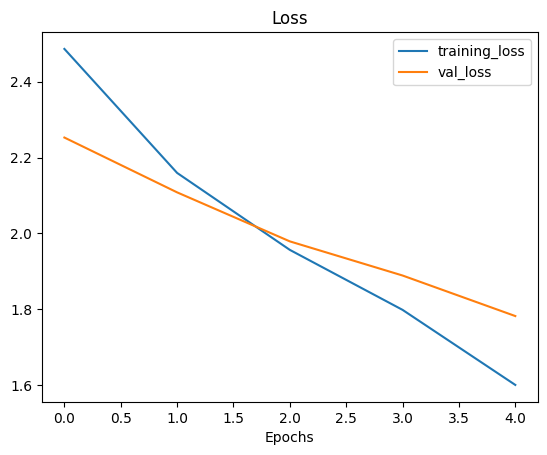

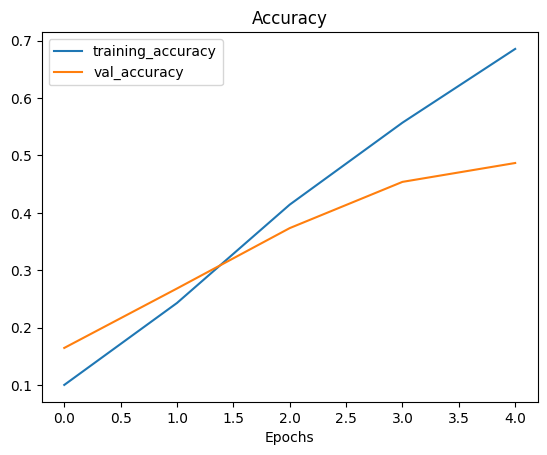

In [32]:
# How do the model with 1% of the and data augmentation loss curve look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning on 10% of data with data augmentation

In [33]:
# get 10% of data
import zipfile
import urllib.request as ur
import shutil

filename = '10_food_classes_10_percent.zip'
url = f'https://storage.googleapis.com/ztm_tf_course/food_vision/{filename}'

if not os.path.exists(f'{ZIP_PATH}/{filename}'):
    # download zip file
    ur.urlretrieve(url, filename)
    shutil.move(filename, f'{ZIP_PATH}')

# unzip the download file
zip_ref = zipfile.ZipFile(f'{ZIP_PATH}/{filename}', 'r')

# remove folder if exist
folder = filename.split('.')[0]
if os.path.isdir(f'{TRANSFER_LEARNING_PATH}/{folder}'):
    shutil.rmtree(f'{TRANSFER_LEARNING_PATH}/{folder}')

zip_ref.extractall(f'{TRANSFER_LEARNING_PATH}')
zip_ref.close()

In [34]:
train_dir_10_percent = f'{TRANSFER_LEARNING_PATH}/{folder}/train'
test_dir = f'{TRANSFER_LEARNING_PATH}/{folder}/test'

In [35]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
LABEL_MODEL = 'categorical'

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            image_size=IMAGE_SHAPE,
                                                                            label_mode=LABEL_MODEL)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMAGE_SHAPE,
                                                                label_mode=LABEL_MODEL)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [36]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# create data augmentation stage with horizontal flipping, rotation, zooms etc..
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # keep for models like ResNet50v2 but EfficientNet's having resclaing built-in
], name="data_augmentation_2")

In [ ]:
# set input shape to our model
input_shape = (224, 224, 3)

# create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNet30(include_top=False)
base_model.trainable = False

# create the inputs and outptus (including the layers in between)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs) # augments our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# create the model_2
model_2 =  tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
model_2.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name=f'{TRANSFER_LEARNING_PATH}/tensorflow_hub', 
                                                                                    experiment_name='10_percent_data_aug')])

## Create a ModelCheckPoint callback

### What are callbacks?

* Callback are a tool which can **add helpfull functionality** to your model during training evaluating or inference
* Some popular callback include:
    * Tensorboard - tf.keras.callbacks.TensorBoard()
    * Model checkpoint - tf.keras.callbacks.ModelCheckpoint()
    * Early Stopping - tf.keras.callbacks.EarlyStopping()

    **TensorBoard** - Log the performance of multiple models and then view and compare these models in a visual way on TensorBoard
    a dashboard for inspecting neural network parameters. Helpfull to compare the results of different model on your data.

    **ModelCheckpoint** - Save your model as it trains so you can stop training if needed and come back to continue off where you left.
    Helpful if training takes a long time and can't be done on sitting.

    **Early Stopping** - Leave you model training for an arbitrary amount of time and have it stop training automatically when it ceases to
    improve. Helpful when you've got a large dataset and don't know how long training will take.

see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

## Extra Base Model Xception

see: https://keras.io/guides/transfer_learning/#build-a-model

In [45]:
# set input shape to our model
input_shape = (224, 224, 3)

# create a frozen base model (also called the backbone)
base_model = tf.keras.applications.Xception(include_top=False,
                                           weights='imagenet', # load weights pre-trained on ImageNet
                                           input_shape=input_shape) # do not include the ImageNet classifier at the top
# freeze the base model
base_model.trainable = False

# create a new model on the top
inputs = tf.keras.Input(shape=input_shape)

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = data_augmentation(inputs) # augments our training images (augmentation doesn't occur on test data)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(10)(x)
model_xception = keras.Model(inputs, outputs)

model_xception.summary(show_trainable=True)

Model: "model_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 7, 7, 2048)        20861480  N          
                                                                            
 global_average_pooling2d_4   (None, 2048)             0         Y          
 (GlobalAveragePooling2D)                                                   
                                                                            
 dropout_3 (Dropout)         (None, 2048)              0         Y          
                                                           

In [48]:
# model_xception.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.CategoricalAccuracy()])

model_xception.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

history_xception = model_xception.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)))

Epoch 1/5


3/3 [==============================] - 7s 2s/step - loss: 8.7677 - accuracy: 0.1143 - val_loss: 9.2435 - val_accuracy: 0.1628
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 11.1440 - accuracy: 0.1714 - val_loss: 10.7739 - val_accuracy: 0.1612
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 11.7993 - accuracy: 0.1571 - val_loss: 11.1538 - val_accuracy: 0.1562
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 12.5133 - accuracy: 0.1714 - val_loss: 11.2074 - val_accuracy: 0.1595
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 12.9842 - accuracy: 0.1714 - val_loss: 11.1514 - val_accuracy: 0.1562


In [50]:
model_xception.evaluate(test_data)

79/79 [==============================] - 36s 454ms/step - loss: 11.1795 - accuracy: 0.1412


[11.179460525512695, 0.1412000060081482]

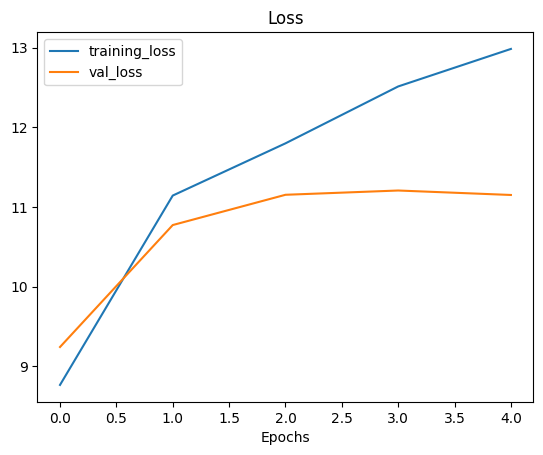

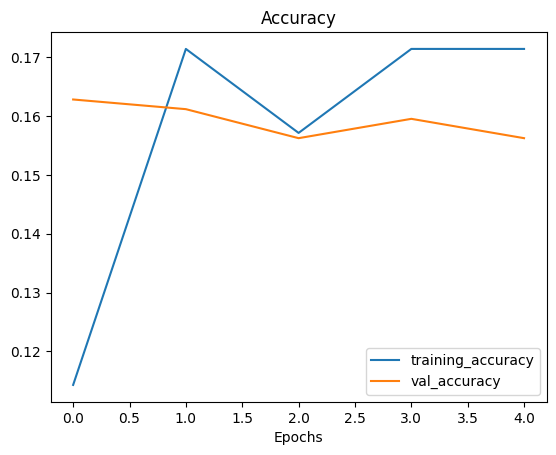

In [49]:
# How do the model with 1% of the and data augmentation loss curve look?
plot_loss_curves(history_xception)